In [41]:
import pandas as pd
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict


import pyarabic.araby as araby

from tashaphyne.stemming import ArabicLightStemmer
import unicodedata
from nltk import  word_tokenize
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

In [42]:
file = pd.read_csv("Data.csv")
file_cleaned = file.dropna().drop_duplicates().reset_index(drop=True).rename(columns={'banque':'review'})

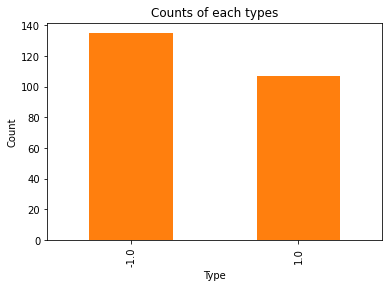

In [43]:
# count of each type 
ax = file_cleaned['polarity'].value_counts().plot(kind='bar',
                                    
                                    color= '#ff7f0e',
                                    title="Counts of each types")
ax.set_xlabel('Type')
ax.set_ylabel('Count');

In [44]:
import codecs
def get_stop_words():
    path = r"C:/Users/belfa/sentiment2/stop-words-list.txt"
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words
def remove_stp_words(text):
    text_words = []
    words = text.split(" ")
    stop_words = get_stop_words()
    for word in words:
        if word not in stop_words and len(word)>2:
            text_words.append(word)
    return ' '.join(text_words)
#Stemmer_LIGHT : Remove suffixes and affixes 
ArListem = ArabicLightStemmer()
def light_stemming(text):
    text_words = []
    words = text.split(" ")
    for c in words:
        stem = ArListem.light_stem(c)
        text_words.append(stem)
    return ' '.join(text_words)
def tokenization(text):
    return set(word_tokenize(text)) 

In [45]:
def clean_text(text):  
    # ref: https://github.com/bakrianoo/aravec
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى",
              "\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","ي","",' ', ' ',' ',' ? ',' ؟ ', ' ! ']
    
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel,"", text)
    
    longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(longation, subst, text)
    
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"[a-zA-Z]", '', text)
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    text = text.strip()
    text=remove_stp_words(text)
    text=tokenization(text)
    return text 

In [46]:
file_cleaned['cleaned_text']= file_cleaned['review'].apply(clean_text)


In [47]:
file_cleaned

,review,polarity,cleaned_text
0,تطبيق جيد، بسيط وفعال لي أنصح بشدة لجميع مالكي...,1.0,"{مالكي, بشده, وفعال, تطبيق, انصح, البنك, جيد, ..."
1,فعال,1.0,{فعال}
2,أوصي بشدة جميع مالكي الحساب في هذا البنك الجيد...,1.0,"{مالكي, بشده, الجيد, البنك, الحساب, اوصي}"
3,بنك جيد جدا!,1.0,"{بنك, جيد}"
4,علة سيئة!,-1.0,"{عله, سيئه}"
...,...,...,...
237,وكالات الشركة غير متواجدة بكل مكان,-1.0,"{وكالات, الشركه, متواجده, بكل, مكان}"
238,ينقصه. الخدمات,-1.0,"{الخدمات, ينقصه}"
239,،انا جربتهم كاملين سيرفس ديالهم زوين,1.0,"{انا, سيرفس, جربتهم, كاملين, ديالهم, زوين}"
240,ابليكاسيون ديالك كايكون فيها شخص لي مكلف بيك ...,1.0,"{مشكل, شخص, ديالك, مكلف, بيه, تتاصل, مكتحتاج, ..."


In [48]:
file_model = file_cleaned.copy()
file_model = file_model[file_model.review.str.len()>1]

In [49]:
file_cleaned

,review,polarity,cleaned_text
0,تطبيق جيد، بسيط وفعال لي أنصح بشدة لجميع مالكي...,1.0,"{مالكي, بشده, وفعال, تطبيق, انصح, البنك, جيد, ..."
1,فعال,1.0,{فعال}
2,أوصي بشدة جميع مالكي الحساب في هذا البنك الجيد...,1.0,"{مالكي, بشده, الجيد, البنك, الحساب, اوصي}"
3,بنك جيد جدا!,1.0,"{بنك, جيد}"
4,علة سيئة!,-1.0,"{عله, سيئه}"
...,...,...,...
237,وكالات الشركة غير متواجدة بكل مكان,-1.0,"{وكالات, الشركه, متواجده, بكل, مكان}"
238,ينقصه. الخدمات,-1.0,"{الخدمات, ينقصه}"
239,،انا جربتهم كاملين سيرفس ديالهم زوين,1.0,"{انا, سيرفس, جربتهم, كاملين, ديالهم, زوين}"
240,ابليكاسيون ديالك كايكون فيها شخص لي مكلف بيك ...,1.0,"{مشكل, شخص, ديالك, مكلف, بيه, تتاصل, مكتحتاج, ..."


In [50]:
sent = [row for row in file_model.cleaned_text]
phrases = Phrases(sent, min_count=2, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[2]


['مالكي', 'بشده', 'الجيد', 'البنك', 'الحساب', 'اوصي']

In [51]:
import multiprocessing

from gensim.models import Word2Vec

In [52]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [53]:
w2v_model = Word2Vec(min_count=2,
                     window=3,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0, 
                     #min_alpha=0.0007, 
                     negative=30,
                     workers=multiprocessing.cpu_count()-1)

In [54]:
t = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [55]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.0 mins


In [56]:
w2v_model.init_sims(replace=True)

<ipython-input-56-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [57]:
w2v_model.wv.most_similar(positive=["احسن"])

[('جربتهم', 0.173588827252388),
 ('شفاره', 0.12867474555969238),
 ('مره', 0.10709137469530106),
 ('اكفس', 0.10297222435474396),
 ('فاشل', 0.10228625684976578),
 ('لقد', 0.09536117315292358),
 ('عيب', 0.09428811073303223),
 ('راه', 0.09251716732978821),
 ('امل', 0.0917428508400917),
 ('حساب', 0.08872448652982712)]

In [58]:
w2v_model.save("word2vec.model")

In [59]:
file_export = file_model.copy()
file_export['text'] = file_export.cleaned_text
file_export.text = file_export.text.str.join(' ')
#file_export.review = file_export.review.apply(lambda x: ' '.join(bigram[x]))
file_export.polarity = file_export.polarity.astype('int8')

In [60]:
#file_cleaned.to_csv('cleaned_data.csv', encoding='utf-8-sig')